# XGBoost : SKLearn API

Read Titanic Data

Split Data : Train, Validation, Test 

Build Model using SKLearn API

Model using Default Parameters

Predict 

Performance Measure on Test Data

Plot Metrics

SHAP Analysis

Cross Validation

Probability Calibration 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
from sklearn import preprocessing 
from sklearn.model_selection import train_test_split

In [3]:
import xgboost as xgb

In [4]:
try:
    from ipywidgets import interact, SelectMultiple
    INTERACTIVE = True
except ImportError:
    INTERACTIVE = False

### Read Data

In [5]:
# import seaborn as sns
# train_df = sns.load_dataset('titanic')
# train_df = train_df.drop(['who','alive','alone'], axis=1)

In [6]:
# """CatBoost"""
# from catboost.datasets import titanic
# train_df, test_df = titanic()

In [7]:
# null_value_stats = train_df.isnull().sum(axis=0)
# null_value_stats[null_value_stats != 0]
# train_df.fillna(np.nan, inplace=True)
# test_df.fillna(np.nan, inplace=True)

In [8]:
# X = train_df.drop('Survived', axis=1)
# y = train_df.Survived

In [9]:
from ipynb.fs.full.dataProcessing_titanicData import *

In [10]:
train_df, test_df = train_test_ordinal

In [11]:
X = train_df.drop('Survived', axis=1)
y = train_df.Survived

#### Split Data

In [12]:
"""Setting the Seed"""
theSeed = 209

In [13]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, train_size=0.80, random_state=theSeed)
print(f'train data: {X_train.shape}')
print(f'valid data: {X_valid.shape}')

train data: (785, 14)
valid data: (197, 14)


In [14]:
#X_test = test_df
X_test = test_df.drop('Survived', axis=1)
y_test = test_df.Survived
print(f'test data : {X_test.shape}')

test data : (327, 14)


#### Setting Weight to the Data

In [15]:
# scale_pos_weight = np.random.rand(X_train.shape[0], )

### Train Model

#### Model With Default Parameters

In [16]:
# param_grid = {
#     'n_estimators': 100,
#     'max_depth': 5,
#     'learning_rate': 0.1,
#     'objective': 'binary',
#     'booster': 'gbtree', 
#     'tree_method': 'auto',
#     'n_jobs': 2,
#     'gamma': 1.0,
#     'min_child_weight': 0.001, 
#     'max_delta_step': 0.0,
#     'subsample': 1.0, 
#     'colsample_bytree': 1.0, 
#     'colsample_bylevel': 1.0,
#     'colsample_bynode': 1.0,
#     'reg_alpha': 0.0, 
#     'reg_lambda': 0.0,
#     'scale_pos_weight': 1.0,
#     'random_state': None,
#     'verbose': False}

In [17]:
model = xgb.XGBClassifier(
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5, 
    learning_rate=0.1, 
    objective='binary:logistic',
    booster='gbtree', 
    tree_method='auto',
    n_jobs=2,
    gamma=0,
    min_child_weight=0.001, 
    max_delta_step=0.0,
    subsample=1.0, 
    colsample_bytree=1.0, 
    colsample_bylevel=1.0,
    colsample_bynode=1.0,
    reg_alpha=0.0, 
    reg_lambda=0.0,
    scale_pos_weight=1.0,
    #verbose=0,
    random_state=None)

In [18]:
fit = model.fit(
    X_train, y_train,
    sample_weight=None, 
    base_margin=None,
    eval_set=[(X_valid, y_valid)],
    eval_metric=['auc','logloss','aucpr'], 
    early_stopping_rounds=None, 
    verbose=False, 
    xgb_model=None, 
    sample_weight_eval_set=None, 
    #base_margin_eval_set=None, 
    feature_weights=None, 
    callbacks=None)

#### Model Evaluation

In [19]:
auc = list(model.evals_result_.values())[0]['auc']
auc = np.array(auc)
print(f"Mean AUC : { round(auc.mean(),4)}")
loss = list(model.evals_result_.values())[0]['logloss']
loss = np.array(loss)
print(f"Mean Loss : { round(loss.mean(),4) }")
aucpr = list(model.evals_result_.values())[0]['aucpr']
aucpr = np.array(aucpr)
print(f"Mean Loss : { round(aucpr.mean(),4) }")

Mean AUC : 0.9691
Mean Loss : 0.2401
Mean Loss : 0.9546


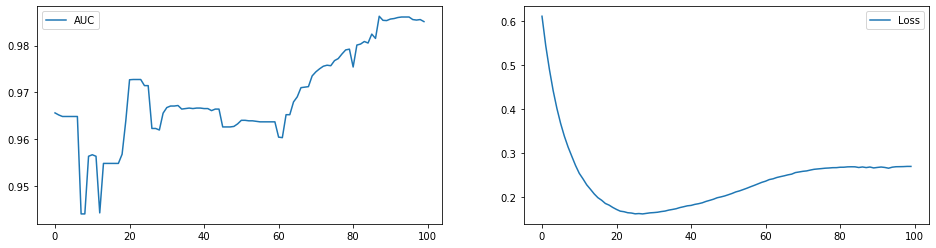

In [20]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(16,4))
ax[0].plot(auc, label='AUC')
ax[1].plot(loss,label='Loss')

ax[0].legend()
ax[1].legend()
plt.show()

### Predict

In [21]:
y_pred = model.predict(
    X_test, 
    output_margin=False, 
    ntree_limit=None, 
    validate_features=True, 
    base_margin=None)

In [22]:
y_score = model.predict_proba(
    X_test, 
    ntree_limit=None, 
    validate_features=True, 
    base_margin=None)

### Performance Metrics on Test Data

In [23]:
from sklearn import metrics

In [24]:
"""Accuracy Score"""
accuracy = metrics.accuracy_score(y_test, y_pred, sample_weight=None, normalize=True)
print( round(accuracy, 4))

0.9664


In [25]:
"""Balanced Accuracy Score"""
balanced_accuracy = metrics.balanced_accuracy_score(y_test, y_pred, sample_weight=None, adjusted=False)
print( round(balanced_accuracy, 4))

0.9628


In [26]:
"""ROC Curve"""
fpr, tpr, thresholds = metrics.roc_curve(y_test, y_score[:,1])

In [27]:
"""AUC"""
auc = metrics.auc(fpr, tpr)
print( round(auc, 4))

0.9867


In [28]:
"""Confusion Matrix"""
metrics.confusion_matrix(y_test, y_pred)

array([[215,   6],
       [  5, 101]])

In [29]:
tn, fp, fn, tp = metrics.confusion_matrix(y_test, y_pred).ravel()
print(f"TN:{tn}, FP:{fp}, FN:{fn}, TP:{tp}")

TN:215, FP:6, FN:5, TP:101


In [30]:
"""F1 Score"""
f1 = metrics.f1_score(y_test, y_pred, labels=None, pos_label=1, average='binary', sample_weight=None)
print( round(f1, 4))

0.9484


In [31]:
"""Log Loss"""
metrics.log_loss(y_test, y_score[:, 1], normalize=True, sample_weight=None, labels=[0,1])

0.2011713419528373

In [32]:
"""Precision, Recall, Fscore, Support"""
metrics.precision_recall_fscore_support(y_test, y_pred, labels=[0,1], pos_label=1, 
                                        average=None, sample_weight=None)

(array([0.97727273, 0.94392523]),
 array([0.97285068, 0.95283019]),
 array([0.97505669, 0.94835681]),
 array([221, 106]))

In [33]:
precision = metrics.precision_score(y_test, y_pred, labels=[0,1], pos_label=1, 
                                    average='binary', sample_weight=None)
print( round(precision, 4))

0.9439


In [34]:
recall = metrics.recall_score(y_test, y_pred, labels=[0,1], pos_label=1, 
                              average='binary', sample_weight=None)
print( round(recall, 4))

0.9528


### Basic Plots

Metrics

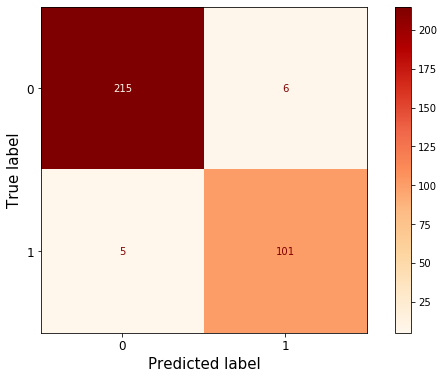

In [35]:
fig, ax = plt.subplots(figsize=(10,6))

ax.set_xlabel("", fontsize=15)
ax.set_ylabel("", fontsize=15)
ax.set_xticklabels([0,1], fontsize=12)
ax.set_yticklabels([0,1], fontsize=12)

metrics.plot_confusion_matrix(
    model, X_test, y_test, 
    labels=None, sample_weight=None, normalize=None, 
    display_labels=[0,1], 
    cmap='OrRd', 
    #color='w',
    ax=ax)

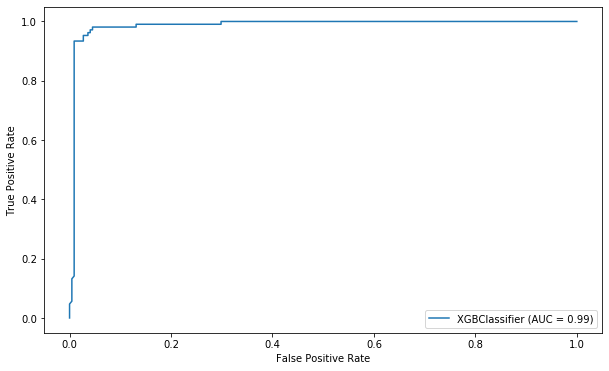

In [36]:
fig, ax = plt.subplots(figsize=(10,6))
metrics.plot_roc_curve(model, X_test, y_test, sample_weight=None, ax=ax)

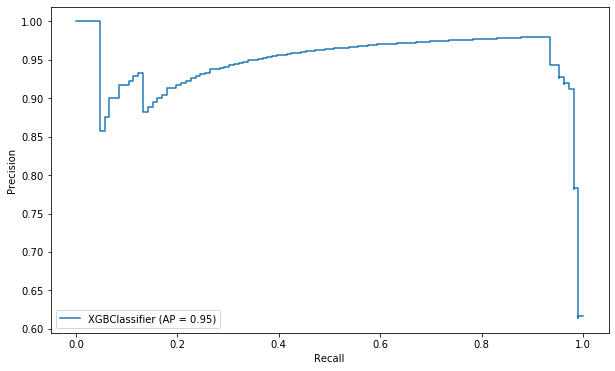

In [37]:
fig, ax = plt.subplots(figsize=(10,6))
metrics.plot_precision_recall_curve(model, X_test, y_test, sample_weight=None, ax=ax)

Feature Importance

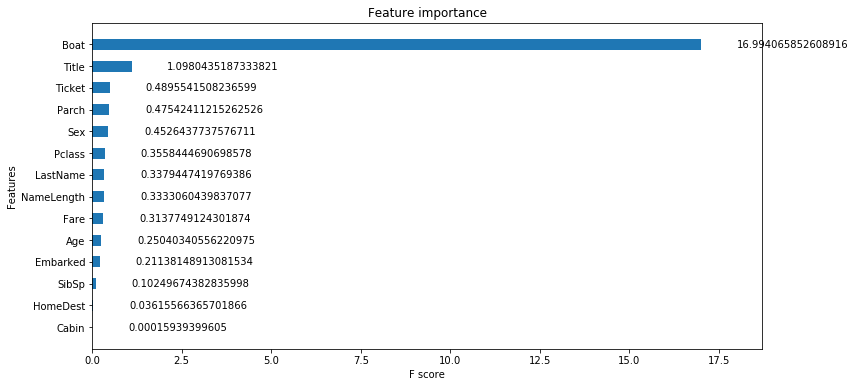

In [38]:
fig, ax = plt.subplots(figsize=(12,6))
xgb.plot_importance(fit, height=0.5, importance_type='gain', grid=False, ax=ax)

Trees

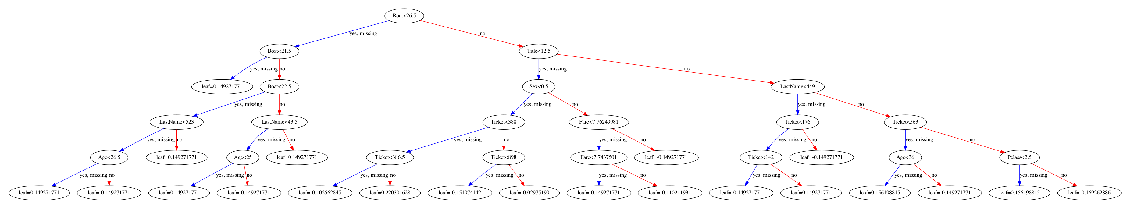

In [39]:
fig, ax = plt.subplots(figsize=(20,20))
xgb.plot_tree(fit, num_trees=4, rankdir='TB', ax=ax)
plt.show()

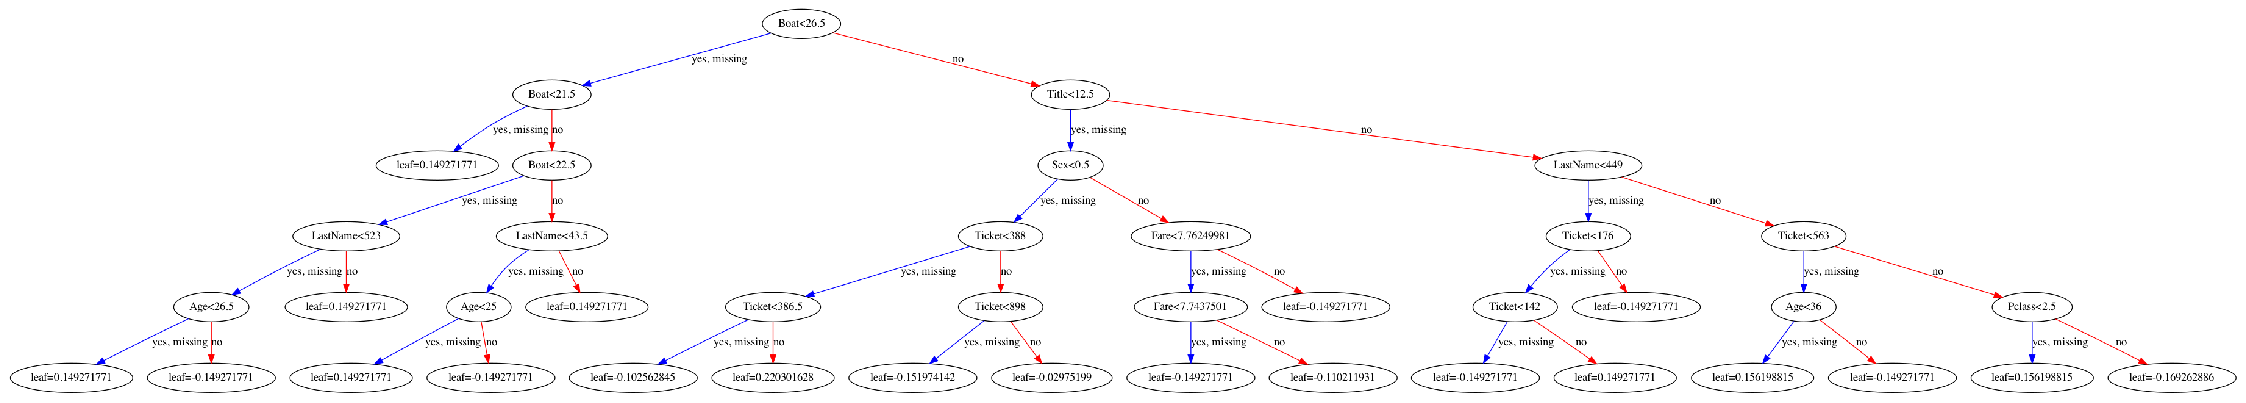

In [40]:
xgb.plot_tree(fit, num_trees=4, rankdir='TB')
fig = plt.gcf()
fig.set_size_inches(40,20)
plt.show()

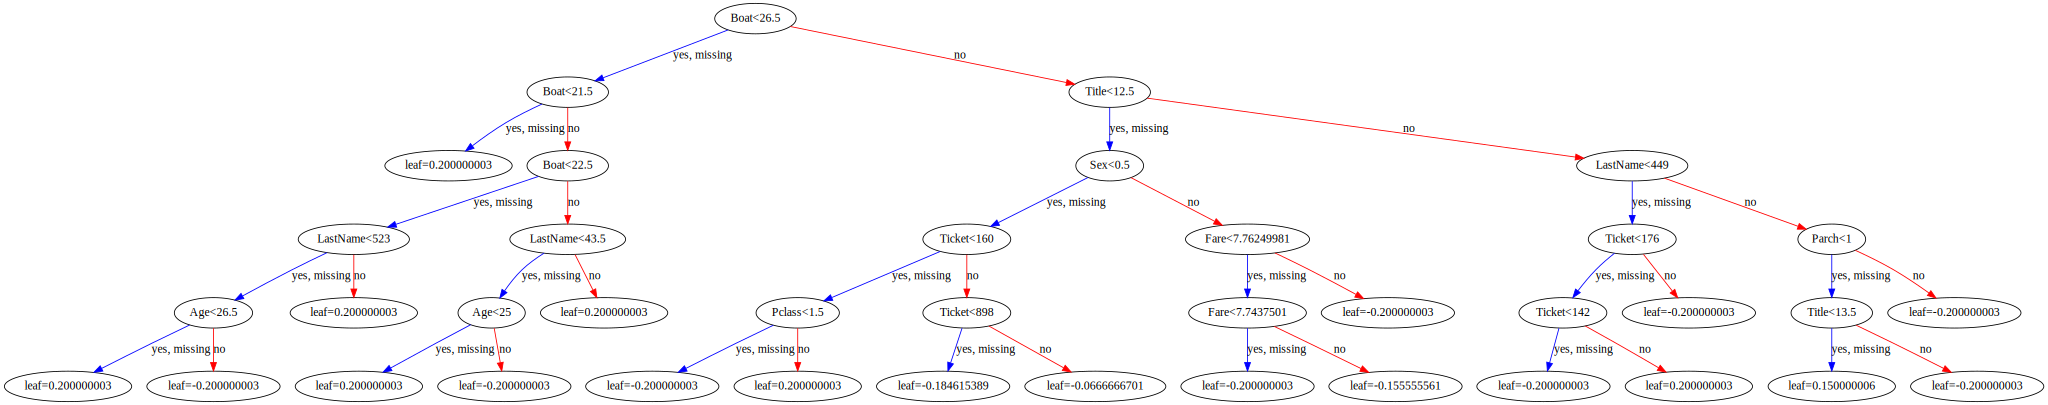

In [41]:
xgb.to_graphviz(fit, num_trees=0, rankdir='UT')

### SHAP Analysis

In [42]:
import shap
shap.initjs()

INFO:tensorflow:Enabling eager execution
INFO:tensorflow:Enabling v2 tensorshape
INFO:tensorflow:Enabling resource variables
INFO:tensorflow:Enabling tensor equality
INFO:tensorflow:Enabling control flow v2


In [43]:
explainer = shap.Explainer(fit)
shap_values = explainer(X_train)

In [44]:
shap_values.shape

(785, 14)

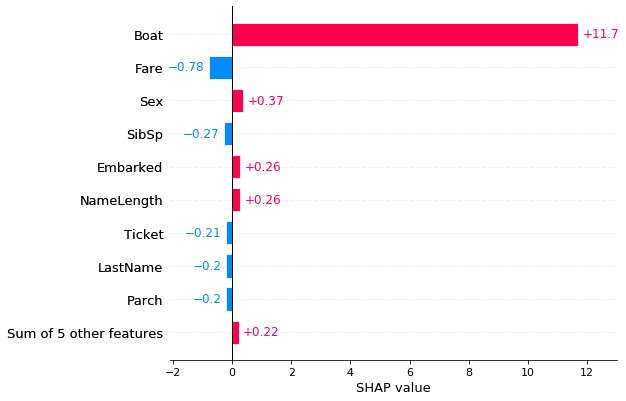

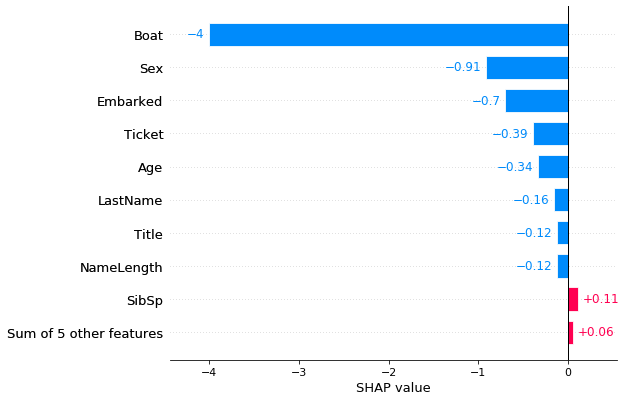

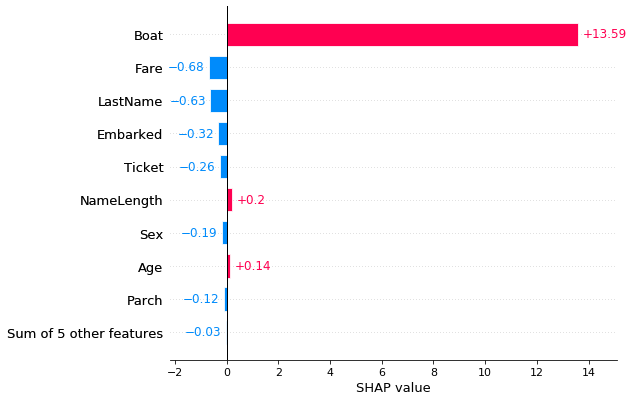

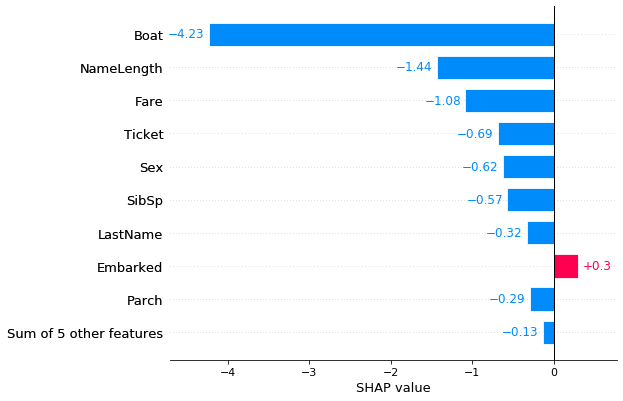

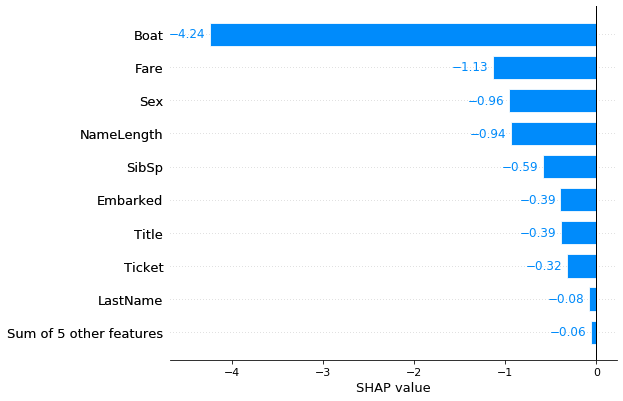

In [45]:
for i in range(5):
    shap.plots.bar(shap_values[i])

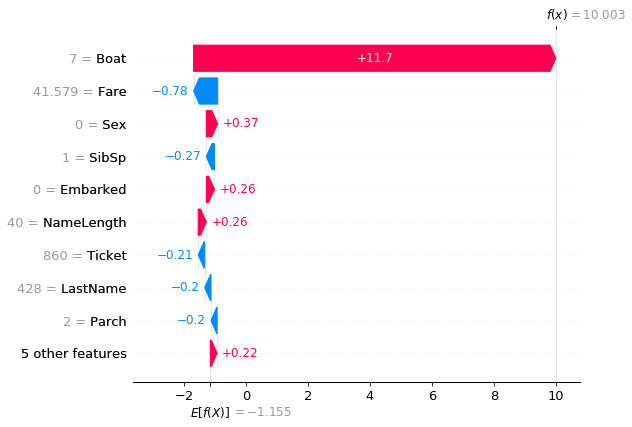

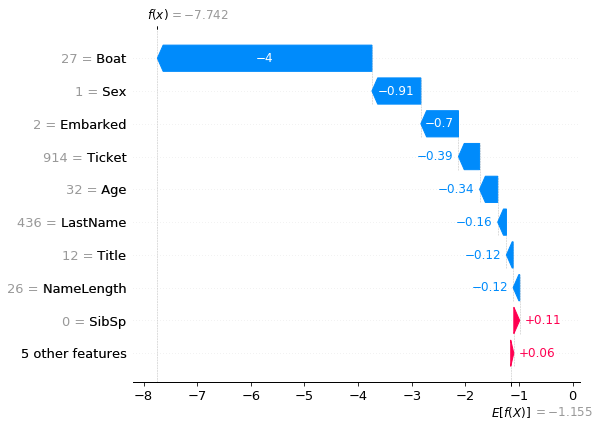

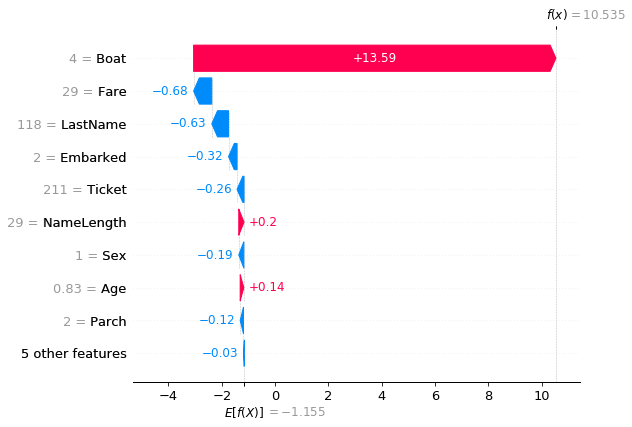

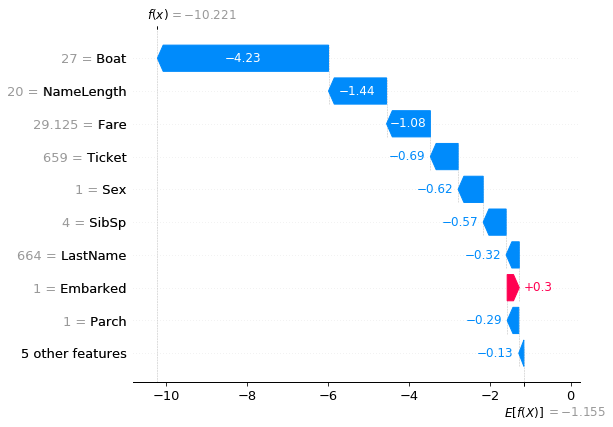

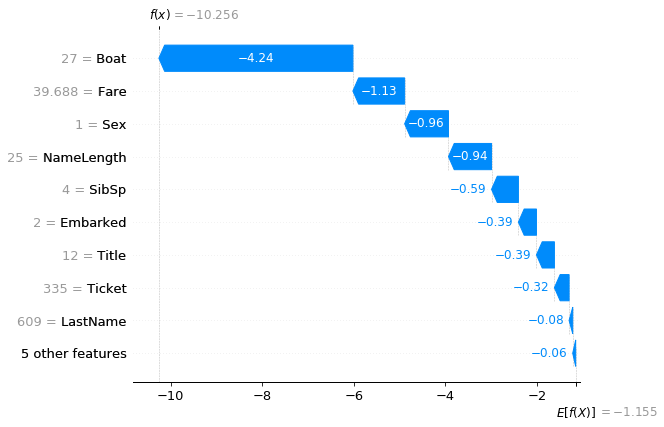

In [46]:
for i in range(5):
    shap.plots.waterfall(shap_values[i])

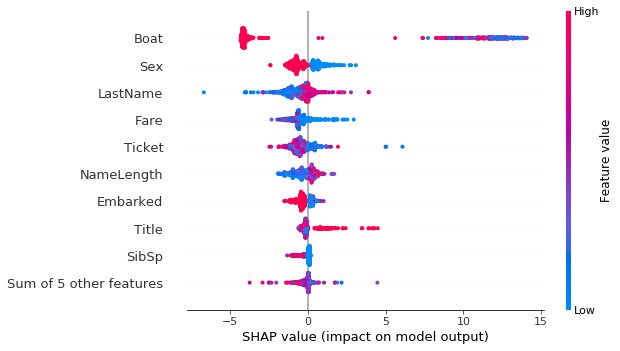

In [47]:
shap.plots.beeswarm(shap_values)

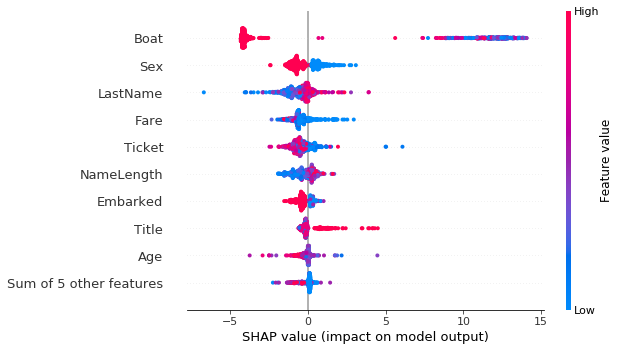

In [48]:
shap.plots.beeswarm(shap_values)

In [49]:
treeExplainer = shap.TreeExplainer(
    model, 
    data=None, 
    feature_perturbation= "tree_path_dependent", 
    model_output='raw')
shap_values = treeExplainer.shap_values(X_train)

Visualize the first Prediction's Explanation

In [50]:
shap.force_plot(treeExplainer.expected_value, shap_values[0,:], X_train.iloc[0,:])

Visualize the first prediction's explanation

In [51]:
shap.force_plot(treeExplainer.expected_value, shap_values[:100,:], X_train.iloc[0:100,:])

SHAP Summary Plot

Summarize the effects of all the features

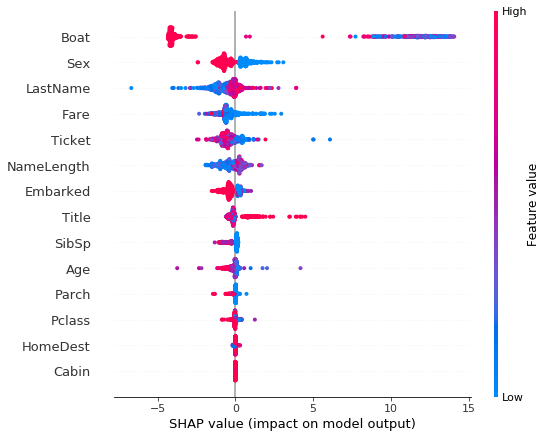

In [52]:
shap.summary_plot(shap_values, X_train)

SHAP Dependence Plot

Create a SHAP dependence plot to show the effect of a single feature across the whole dataset

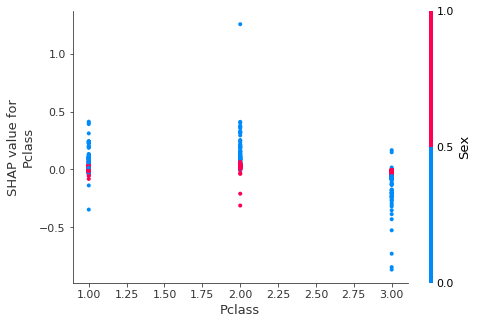

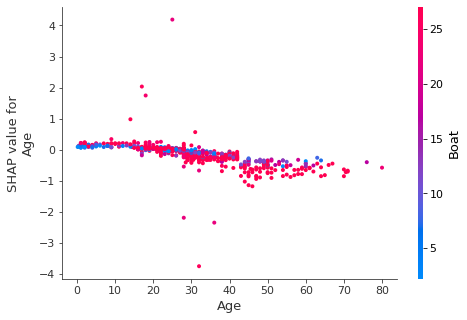

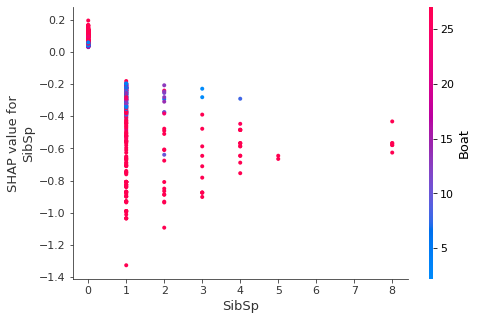

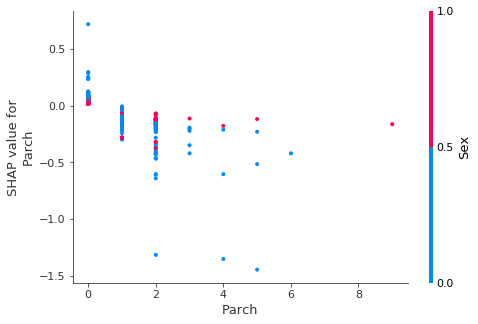

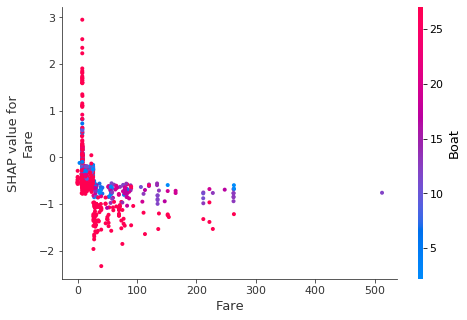

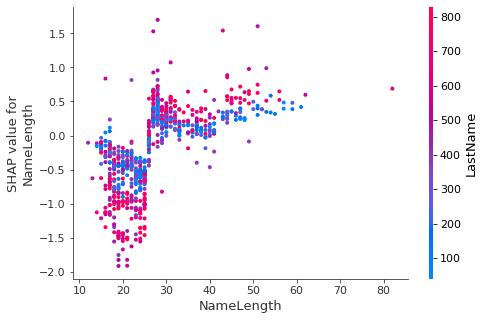

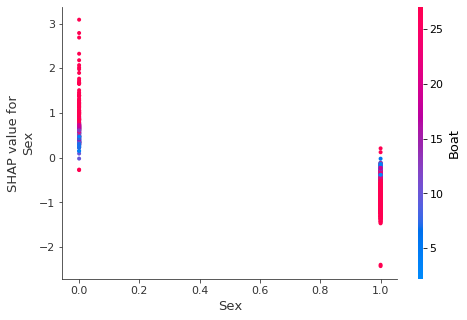

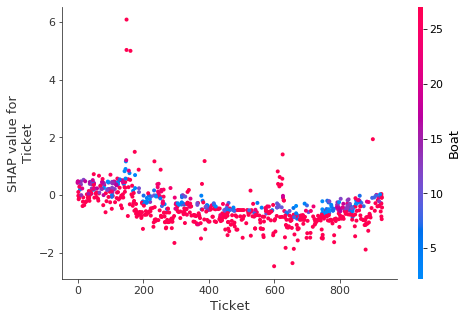

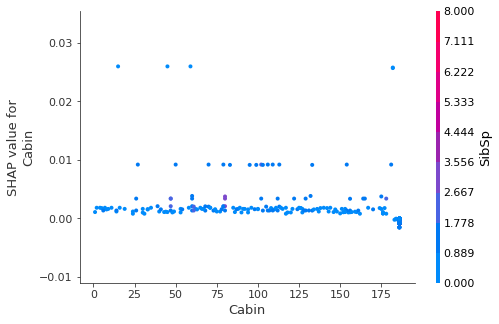

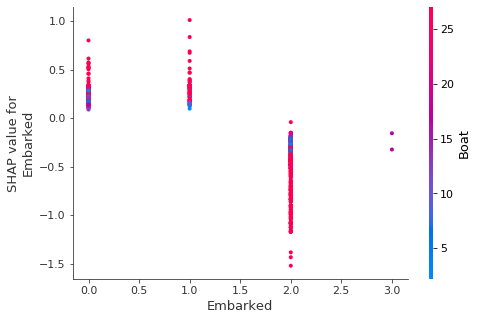

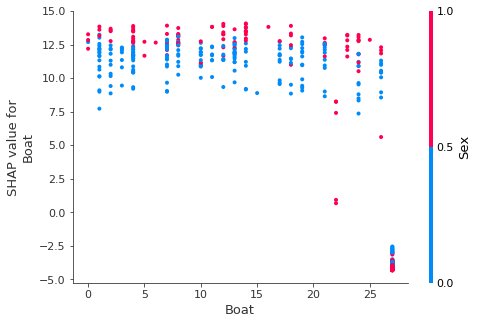

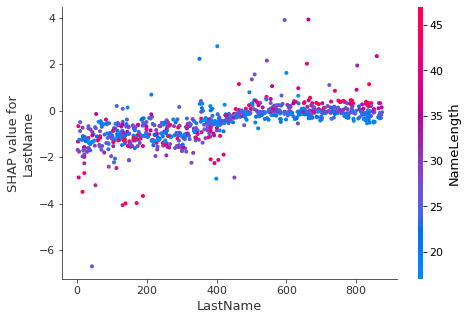

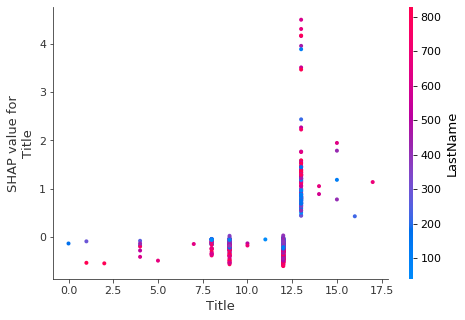

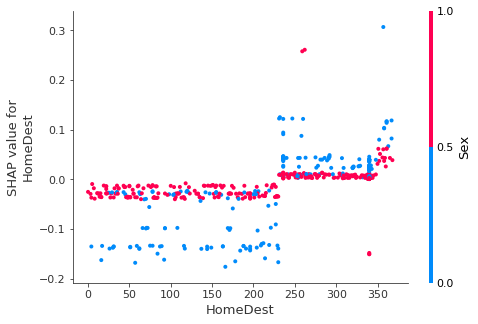

In [53]:
for name in X_train.columns:
    shap.dependence_plot(name, shap_values, X_train, display_features=X_train)

### Cross-Validation 

In [54]:
from sklearn.model_selection import cross_val_predict, cross_val_score, cross_validate

#### Model with Default Parameters

In [55]:
cvmodel = xgb.XGBClassifier(
    use_label_encoder=False,
    n_estimators=100,
    max_depth=5, 
    learning_rate=0.1, 
    objective='binary:logistic',
    booster='gbtree', 
    tree_method='auto',
    n_jobs=2,
    gamma=0,
    min_child_weight=0.001, 
    max_delta_step=0.0,
    subsample=1.0, 
    colsample_bytree=1.0, 
    colsample_bylevel=1.0,
    colsample_bynode=1.0,
    reg_alpha=0.0, 
    reg_lambda=0.0,
    scale_pos_weight=1.0,
    #verbose=0,
    random_state=None)

In [56]:
y_pred = cross_val_predict(cvmodel, X_train, y_train, cv=5)

[14:42:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:27] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

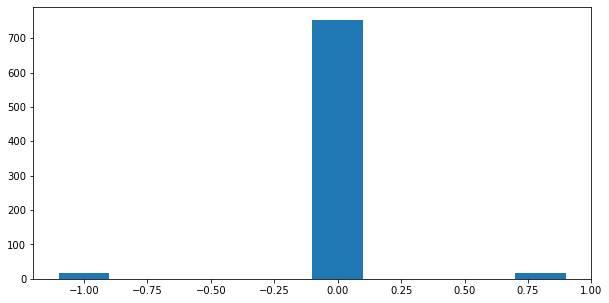

[0.02038217 0.         0.         0.         0.         0.95923567
 0.         0.         0.         0.02038217]


In [57]:
fig, ax = plt.subplots( figsize=(10,5) )

y_delta = y_train.to_numpy() - y_pred
n, bins, patches = ax.hist(y_delta, density=False, histtype='bar', rwidth=2.5, align='left', stacked=False)
plt.show()
print( n/len(y_pred) )

In [58]:
# fig, ax = plt.subplots( figsize=(12,7) )
# ax.scatter(y_train.to_numpy(), y_pred, edgecolors=(0, 0, 0))
# ax.plot([y_train.min(), y_train.max()], [y_train.min(), y_train.max()], 'k--', lw=4)
# ax.set_xlabel('Observed')
# ax.set_ylabel('Predicted')
# plt.show()

In [59]:
scores = cross_val_score(cvmodel, X_train, y_train, scoring='accuracy', cv=5)
scores

[14:42:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

array([0.97452229, 0.96178344, 0.97452229, 0.97452229, 0.91082803])

In [60]:
scores = cross_validate(cvmodel, X_train, y_train, scoring=['accuracy','roc_auc','f1'], cv=5)
scores

[14:42:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[14:42:28] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective

{'fit_time': array([0.08890009, 0.07934594, 0.08226609, 0.08116674, 0.07183218]),
 'score_time': array([0.00430417, 0.00423598, 0.00440788, 0.00489497, 0.00402999]),
 'test_accuracy': array([0.97452229, 0.96178344, 0.97452229, 0.97452229, 0.91082803]),
 'test_roc_auc': array([0.99512769, 0.99613575, 0.97731855, 0.98919284, 0.97011145]),
 'test_f1': array([0.96875   , 0.95454545, 0.96774194, 0.96774194, 0.890625  ])}

### Probability Calibration

In [61]:
from sklearn.calibration import CalibratedClassifierCV

In [62]:
calibrated_model = CalibratedClassifierCV(base_estimator=model, method='sigmoid', cv='prefit')

In [63]:
calibrated_fit = calibrated_model.fit(X_test, y_test)

In [64]:
calibrated_y_pred  = calibrated_fit.predict(X_test)
calibrated_y_score = calibrated_fit.predict_proba(X_test)

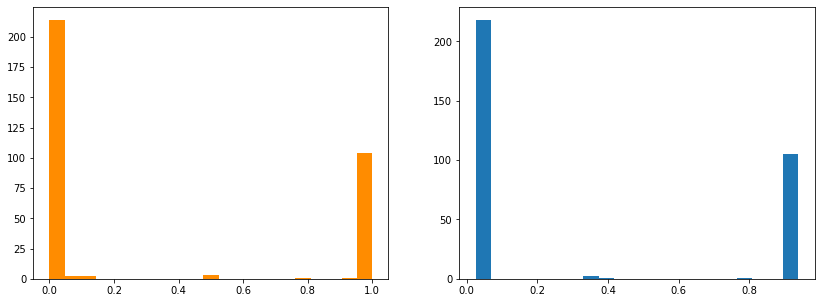

In [65]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (14,5))
ax[0].hist(y_score[:,1], bins=21, color='darkorange')
ax[1].hist(calibrated_y_score[:,1], bins=21)
plt.show()

#### Calibration Curve

In [66]:
from sklearn.calibration import calibration_curve

In [67]:
pdf = pd.DataFrame({'y_test': y_test, 'y_score': y_score[:,1]})
pdf #= pdf.sort_values(by='y_score', ascending=True)
pdf['pbin'] = pd.cut( pdf['y_score'], bins=10, labels=['G'+str(x) for x in range(10)])

In [68]:
pdf.groupby('pbin').agg({'y_test': 'sum'})

,y_test
pbin,
G0,4
G1,1
G2,0
G3,0
G4,0
G5,1
G6,0
G7,1
G8,0


In [69]:
pdf

,y_test,y_score,pbin
0,0,0.999976,G9
1,0,0.000124,G0
2,0,0.000941,G0
3,0,0.000032,G0
4,1,0.999946,G9
...,...,...,...
322,1,0.999941,G9
323,0,0.000060,G0
324,0,0.000049,G0
325,0,0.000090,G0


In [70]:
bins = np.linspace(0, 1, 10 + 1)
bins

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ])

In [71]:
binids = np.digitize(y_score[:,1], bins) - 1 
binids

array([9, 0, 0, 0, 9, 9, 0, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 9, 9, 9, 0, 0,
       0, 9, 9, 0, 9, 0, 9, 0, 0, 9, 0, 9, 9, 9, 0, 0, 0, 0, 9, 0, 0, 9,
       9, 9, 0, 0, 9, 0, 9, 0, 9, 9, 0, 0, 0, 0, 9, 9, 0, 0, 0, 0, 0, 0,
       0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 9, 9, 9, 9, 0, 0, 0, 9, 4, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0, 9, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 9, 9, 0, 9, 0, 9, 9, 0, 0, 0, 0, 0, 0, 0, 9, 9, 0, 0,
       9, 0, 9, 9, 0, 0, 0, 0, 0, 9, 9, 0, 0, 0, 9, 9, 0, 9, 0, 0, 0, 0,
       0, 0, 9, 0, 0, 9, 0, 9, 9, 1, 0, 0, 9, 0, 9, 0, 0, 9, 0, 0, 0, 9,
       0, 0, 9, 0, 0, 0, 0, 5, 9, 9, 9, 0, 9, 0, 9, 9, 0, 0, 0, 0, 9, 9,
       0, 0, 9, 0, 0, 0, 9, 0, 0, 9, 9, 0, 0, 9, 0, 0, 0, 0, 0, 9, 0, 0,
       0, 0, 0, 0, 0, 9, 0, 7, 0, 0, 0, 9, 0, 0, 0, 9, 9, 0, 0, 9, 0, 0,
       0, 9, 0, 0, 0, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 0, 9, 0, 0, 9, 0,
       0, 0, 0, 4, 9, 9, 0, 9, 0, 9, 0, 0, 9, 0, 0, 0, 0, 0, 0, 9, 0, 9,
       0, 9, 0, 9, 0, 0, 0, 0, 0, 0, 0, 0, 0, 9, 9,

In [72]:
bin_sums = np.bincount(binids, weights=y_score[:,1], minlength=len(bins))

In [73]:
bin_sums

array([  0.46989409,   0.11592265,   0.        ,   0.        ,
         0.96743092,   0.51227778,   0.        ,   0.78398365,
         0.        , 104.87640107,   0.        ])

In [74]:
bin_total = np.bincount(binids, minlength=len(bins))
bin_total

array([217,   1,   0,   0,   2,   1,   0,   1,   0, 105,   0])

In [75]:
bin_total != 0

array([ True,  True, False, False,  True,  True, False,  True, False,
        True, False])